In [16]:
import os
import pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.collections as cl
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
    bases = list(seq) 
    # check if the input sequence is actually DNA
    # If there is any letter ather than ATCG, this function will alert an error 
    for base in bases:
        if base not in complement.keys():
            print "not DNA"  
    # actual reverse complement processes 
    complement_bases = [complement[base] for base in bases] 
    complement_seq = ''.join(complement_bases)
    reverse_complement_seq = complement_seq[::-1] # possible to do this on list as well by reversed(list)  
    return reverse_complement_seq# Change DNA to RNA

def gff_plus_strand(gff_file):   
    # a function to get the sequence of E coli genome from GFF file
    # output is string
    with open(gff_file) as fh:
        plus_strand = ''
        flag = 0
        for line in fh:
            if line[0] == ">":
                flag = 1
                continue
            if flag == 0:
                continue
            plus_strand = plus_strand + line[:-1]
    return plus_strand 

In [7]:
gff_file = 'coli.gff'
plus_strand_sequence = gff_plus_strand(gff_file)

In [ ]:
outputfile2 = '/home/kazuki/^data_analysis/^Ecoli_Genome/Positions_ATG_InRNA.csv'
Positions_DataFrame = pd.read_csv(outputfile2)
Positions_DataFrame = Positions_DataFrame.loc[:,~Positions_DataFrame.columns.str.contains('^Unnamed')]

Start = Positions_DataFrame['At_start'].notnull()
notStart = Positions_DataFrame['At_start'].isnull()

inRNA = Positions_DataFrame['In_RNA']=='yes'
not_inRNA = Positions_DataFrame['In_RNA'].isnull()

strong_at_CCUCC = Positions_DataFrame['Vs_uCCUCCa'] <= -4
Not_strong_at_CCUCC = Positions_DataFrame['Vs_uCCUCCa'] > -4
weak_at_CCUCC = Positions_DataFrame['Vs_uCCUCCa'] > 0

In [14]:
down_for_fasta = 30
up_for_fasta = 30

In [21]:
if not os.path.exists('kpLogo'):
    os.makedirs('kpLogo')
if not os.path.exists('kpLogo/fasta'):
    os.makedirs('kpLogo/fasta')
if not os.path.exists('kpLogo/results'):
    os.makedirs('kpLogo/results')

# Annotated with weakSD VS Non-annotated

In [22]:
df_to_use = Positions_DataFrame[Start & inRNA & weak_at_CCUCC]
fasta = 'kpLogo/fasta/Start_weakSD.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [23]:
df_to_use = Positions_DataFrame[notStart & inRNA]
fasta = 'kpLogo/fasta/Nonstart.fasta'

with open(fasta, 'w') as f_o:
    for index in df_to_use.index:
        if df_to_use.loc[index,'strand'] == '+':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-down_for_fasta-1
            end = ATG+up_for_fasta-1
            seq = plus_strand_sequence[start:end]
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')
        if df_to_use.loc[index,'strand'] == '-':
            ATG = df_to_use.loc[index,'ATG']
            start = ATG-up_for_fasta
            end = ATG+down_for_fasta
            r_seq = plus_strand_sequence[start:end]
            seq = reverse_complement(r_seq)
            f_o.write('>'+str(ATG)+'\n')
            f_o.write(seq+'\n')      

In [77]:
kpLogo = '^tools/kpLogo-1.1/bin/kpLogo'

positive = 'kpLogo/fasta/Start_weakSD.fasta'
background = 'kpLogo/fasta/Nonstart.fasta'
output = 'kpLogo/results/annoVSnonanno'

command = '%s %s -bgfile %s -o %s' % (
    kpLogo,
    positive,
    background,
    output
    )
print command
os.system(command)

^tools/kpLogo-1.1/bin/kpLogo kpLogo/fasta/Start_weakSD.fasta -bgfile kpLogo/fasta/Nonstart.fasta -o kpLogo/results/annoVSnonanno


0

In [80]:
# convert pdf to png for embedding Logo images in the notebook
# install pdf2image
# install pillow
# install poppler
from pdf2image import convert_from_path
path = output+'.pdf'
images = convert_from_path(path)
images[0].save(output+'.png', 'png')

#### img src='kpLogo/results/annoVSnonanno.png'
<img src='kpLogo/results/annoVSnonanno.png'>

# Non-annotated with high initiation score VS Non-annotated with low initiation score 

In [102]:
######################################################
### reads with 21-24nt were used for this analysis ###
######################################################

In [81]:
def RCRPM_loading_readlength(RC,RPM,filename,endtype,densitypath,readlength):    
    with open(densitypath+filename+endtype+'_'+readlength+'_readcounts.pickle', 'rb') as f:
            RC[filename+'_'+readlength]=pickle.load(f)

In [82]:
import multiprocessing
import threading
from datetime import datetime

manager = multiprocessing.Manager()
RC = manager.dict()
RPM = manager.dict()

jobs = []
    
############# 
readlength = '21222324'
#############
   
filenames = ['ks170']
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20190503/density_RL/density_V_options_2/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading_readlength, args=(RC,RPM,filename,endtype,densitypath,readlength))
    jobs.append(job)
    job.start()      
    
[job.join() for job in jobs] # just to get the time by the below line

2019-08-31 12:34:05.218441
2019-08-31 12:34:17.717179


In [88]:
def threshold(cut_off,readcountsf_plus, position, upstream_length,downstream_length):
    if sum(readcountsf_plus[position-upstream_length:position+downstream_length])>=cut_off:
        return 'yes'
    else:
        return 'no'
    
def peak_ratio(cut_off,readcounts,positions,upstream_length,downstream_length,peak_upstream,peak_downstream):
    peaks = {}
    peaks['+']={}
    peaks['-']={}
    
    total_plus = 0
    readcounts_plus = readcounts[0][readcounts[0].keys()[0]]
    #rpm_plus = rpm[0][rpm[0].keys()[0]]
    position_plus = positions['+']
    for position in position_plus:
        cut_off_result = threshold(cut_off,readcounts_plus,position,upstream_length,downstream_length)
        if cut_off_result == 'yes':  
            total_read = sum(readcounts_plus[position-upstream_length-1:position+downstream_length-1])
            peak_read = sum(readcounts_plus[position-peak_upstream-1:position+peak_downstream-1])
            if total_read!=0 and peak_read!=0:
                total_plus+=1
                total_average = float(total_read)/len(readcounts_plus[position-upstream_length-1:position+downstream_length-1])
                peak_average = float(peak_read)/len(readcounts_plus[position-peak_upstream-1:position+peak_downstream-1])
                if total_average !=0:
                    peak_ratio = float(peak_average)/total_average
                    if peak_ratio != 0:
                        peaks['+'][position]=peak_ratio
            
    total_minus = 0
    readcounts_minus = readcounts[1][readcounts[1].keys()[0]]
    #rpm_minus = rpm[1][rpm[1].keys()[0]]
    position_minus = positions['-']
    for position in position_minus:
        cut_off_result = threshold(cut_off,readcounts_minus,position,downstream_length,upstream_length)# opposite as minus       
        if cut_off_result == 'yes':   
            total_read = sum(readcounts_minus[position-downstream_length:position+upstream_length])
            peak_read = sum(readcounts_minus[position-peak_downstream:position+peak_upstream])
            if total_read!=0:
                total_minus+=1
                total_average = float(total_read)/len(readcounts_minus[position-downstream_length:position+upstream_length])
                peak_average = float(peak_read)/len(readcounts_minus[position-peak_downstream:position+peak_upstream])
                if total_average !=0:
                    peak_ratio = float(peak_average)/total_average
                    if peak_ratio != 0:
                        peaks['-'][position]=peak_ratio

    return peaks

"""
def get_position_dict(df):
    df.reset_index(inplace=True)
    position_dict = {}
    position_dict['+']=[]
    position_dict['-']=[]
    for i in range(len(df)):
        if df.loc[i,'strand'] == '+':
            position_dict['+'].append(df.loc[i,'ATG'])
        if df.loc[i,'strand'] == '-':
            position_dict['-'].append(df.loc[i,'ATG'])
    return position_dict


def get_log2PeakScore(peaks):
    FD=[]
    for strand in peaks.keys():
        FD = FD + peaks[strand].values()
    print len(FD)
    return np.log2(FD)
"""

In [97]:
distance = 50
PeakScore_threshold = 1.5

threshold_setting = 10
peak_upstream = -3
peak_downstream = 21
upstream_length_setting = distance
downstream_length_setting = distance
graph_upstream = upstream_length_setting-25
graph_downstream = upstream_length_setting+50

########################################################################


#####
high_group={}   
f = 'ks170'
readcounts = RC[f+'_21222324']
df = Positions_DataFrame[notStart&inRNA]
df.reset_index(inplace=True)

position_dict = {}
position_dict['+']=[]
position_dict['-']=[]
for i in range(len(df)):
    if df.loc[i,'strand'] == '+':
        position_dict['+'].append(df.loc[i,'ATG'])
    if df.loc[i,'strand'] == '-':
        position_dict['-'].append(df.loc[i,'ATG'])
positions = position_dict

#####
peaks=peak_ratio(threshold_setting,readcounts,positions,upstream_length_setting,downstream_length_setting,peak_upstream,peak_downstream)


#####
high_group[f]={}
for strand in peaks.keys():
    high_group[f][strand]={}
    for position in peaks[strand].keys():
        if np.log2(peaks[strand][position]) > PeakScore_threshold:
            high_group[f][strand][position] = peaks[strand][position]

            
#####           
plus_strand = Positions_DataFrame['strand'] == '+'
minus_strand = Positions_DataFrame['strand'] == '-' 

high_group_plus = Positions_DataFrame['ATG'].isin(high_group[f]['+'])
high_group_minus = Positions_DataFrame['ATG'].isin(high_group[f]['-'])
normal_group_plus = Positions_DataFrame['ATG'].isin(high_group[f]['+']) == False
normal_group_minus = Positions_DataFrame['ATG'].isin(high_group[f]['-']) == False

In [98]:
down_for_fasta = 30
up_for_fasta = 30

df = Positions_DataFrame[notStart&inRNA]

for IS_type in ['IS_high','IS_low']:
    if IS_type=='IS_high':
        df1_1=df[high_group_plus & plus_strand]
        df1_2=df[high_group_minus & minus_strand]
        df_to_use = pd.concat([df1_1,df1_2])
    if IS_type=='IS_low':
        df2_1=df[normal_group_plus & plus_strand]
        df2_2=df[normal_group_minus & minus_strand]
        df_to_use = pd.concat([df2_1,df2_2])
        
    fasta = 'kpLogo/fasta/'+IS_type+'.fasta'
    
    with open(fasta, 'w') as f_o:
        for index in df_to_use.index:
            if df_to_use.loc[index,'strand'] == '+':
                ATG = df_to_use.loc[index,'ATG']
                start = ATG-down_for_fasta-1
                end = ATG+up_for_fasta-1
                seq = plus_strand_sequence[start:end]
                f_o.write('>'+str(ATG)+'\n')
                f_o.write(seq+'\n')
            if df_to_use.loc[index,'strand'] == '-':
                ATG = df_to_use.loc[index,'ATG']
                start = ATG-up_for_fasta
                end = ATG+down_for_fasta
                r_seq = plus_strand_sequence[start:end]
                seq = reverse_complement(r_seq)
                f_o.write('>'+str(ATG)+'\n')
                f_o.write(seq+'\n') 

In [99]:
kpLogo = '^tools/kpLogo-1.1/bin/kpLogo'

positive = 'kpLogo/fasta/IS_high.fasta'
background = 'kpLogo/fasta/IS_low.fasta'
output = 'kpLogo/results/InitiationScore'

command = '%s %s -bgfile %s -o %s' % (
    kpLogo,
    positive,
    background,
    output
    )
print command
os.system(command)

^tools/kpLogo-1.1/bin/kpLogo kpLogo/fasta/IS_high.fasta -bgfile kpLogo/fasta/IS_low.fasta -o kpLogo/results/InitiationScore


0

In [100]:
# convert pdf to png for embedding Logo images in the notebook
# install pdf2image
# install pillow
# install poppler
from pdf2image import convert_from_path
path = output+'.pdf'
images = convert_from_path(path)
images[0].save(output+'.png', 'png')

#### img src='kpLogo/results/InitiationScore.png'
<img src='kpLogo/results/InitiationScore.png'>

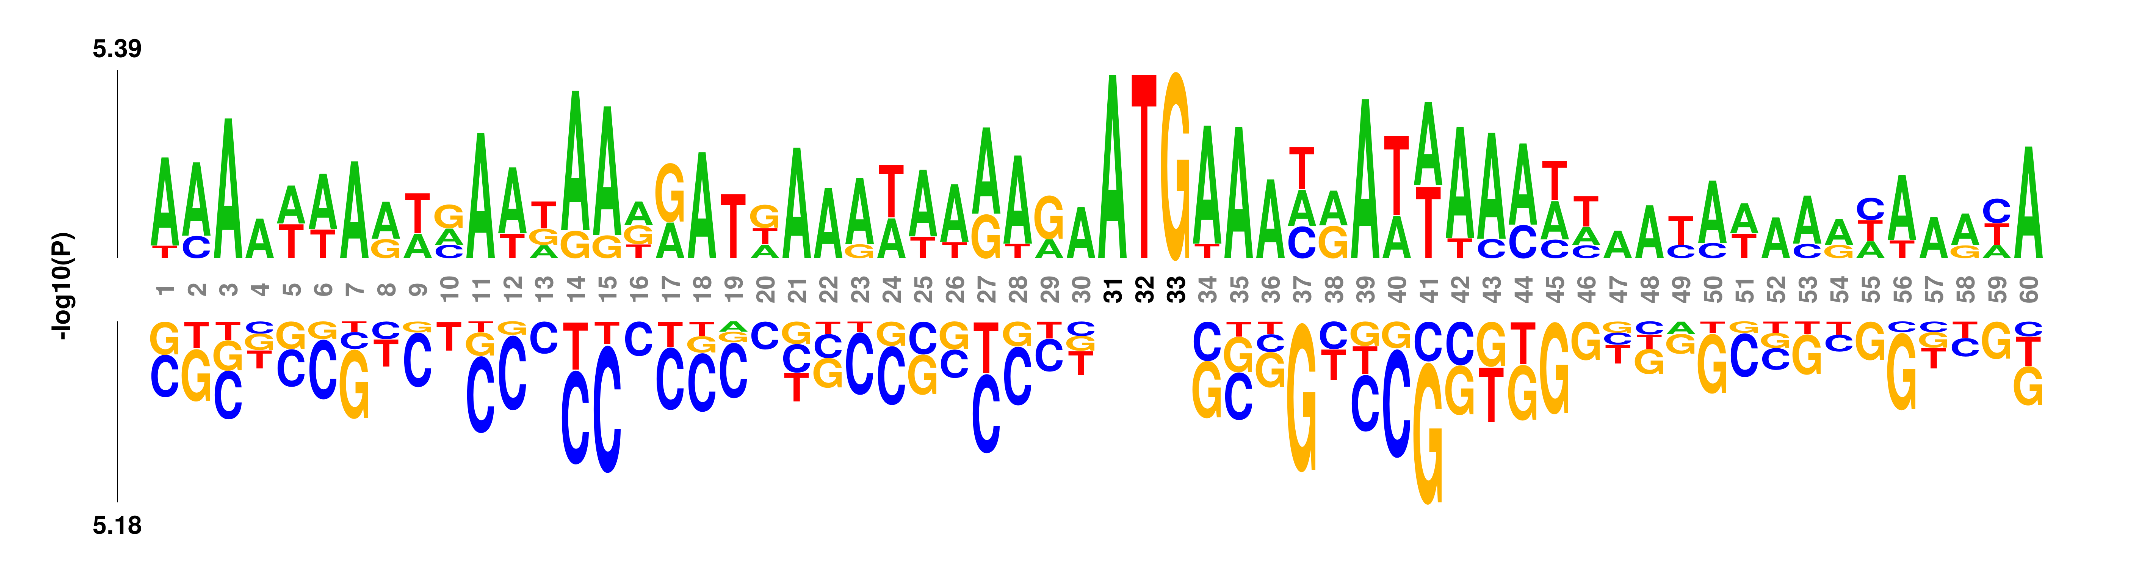

In [133]:
img = mpimg.imread('kpLogo/results/InitiationScore.png')
plt.figure(figsize=(50, 10))
imgplot = plt.imshow(img)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.show()

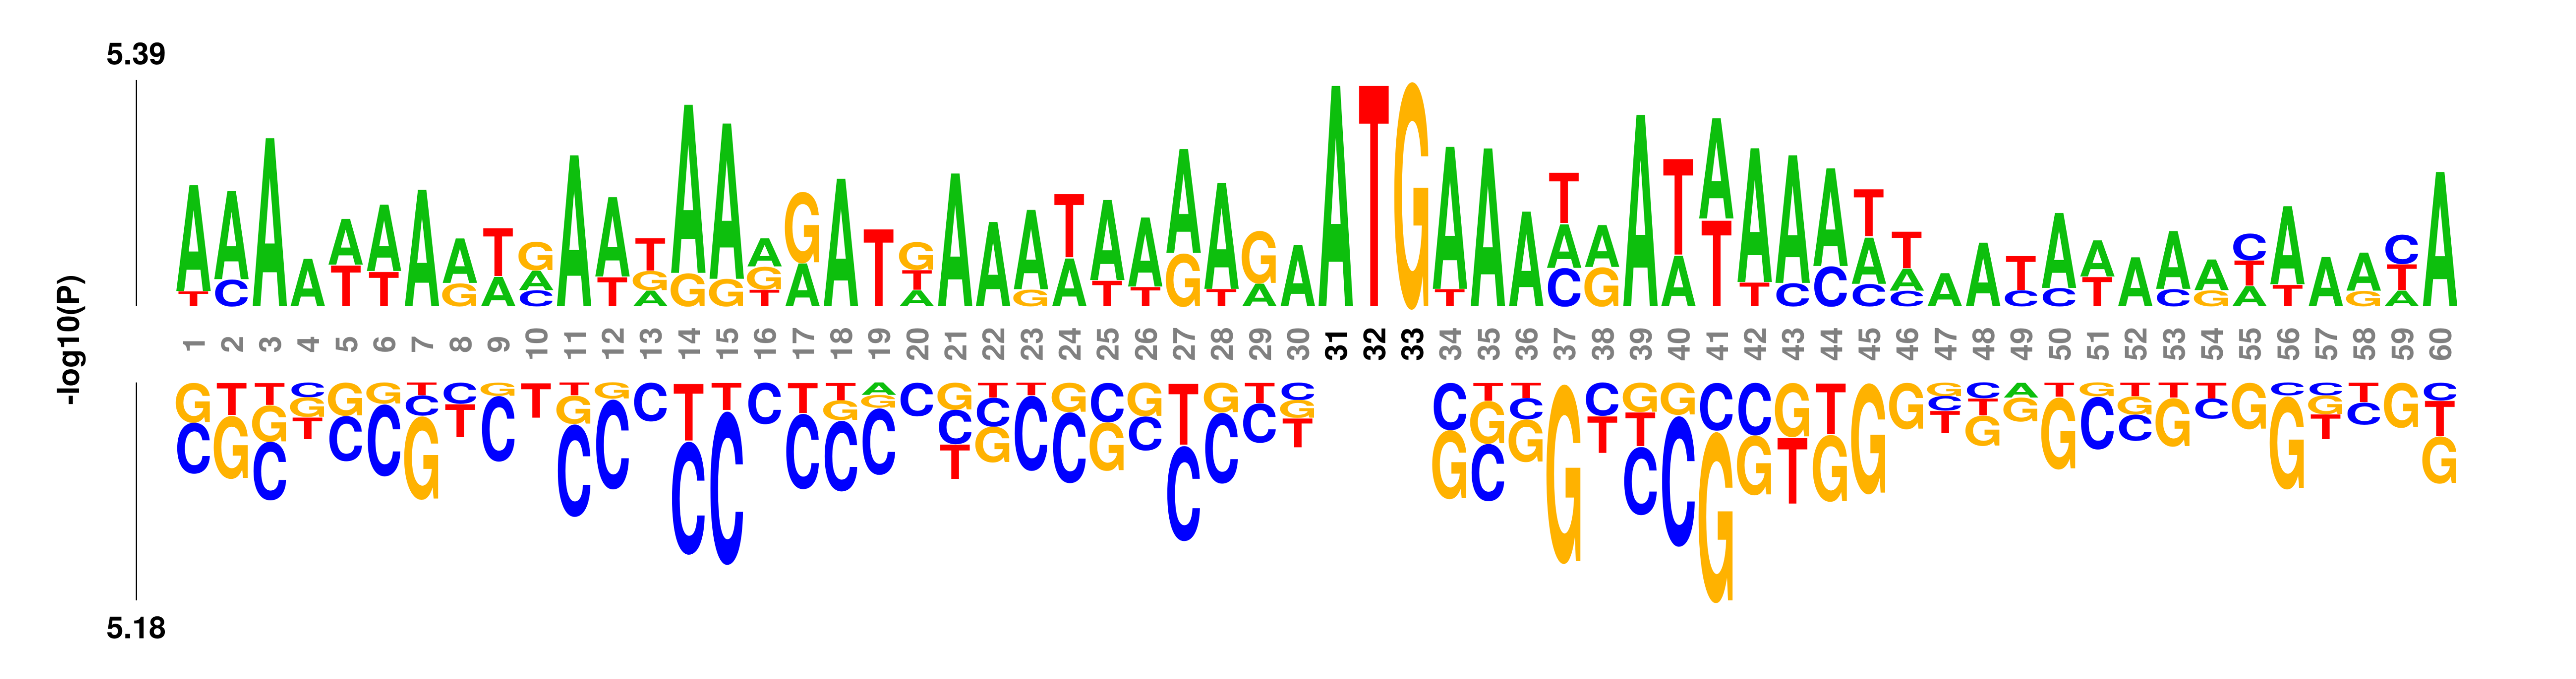

In [ ]:
, dpi=100